In [10]:
from numpy.random import seed
seed(35)
from tensorflow import set_random_seed
set_random_seed(35)


from general_loader import ds_from_db
from data_manipulation import remove_outlier
import numpy as np
from sklearn.model_selection import train_test_split
from keras import backend as K

from ae_designs_depth import model_7h, model_5h, model_3h
from secTools import yamlLoad
from general_loader import ds_from_db
from data_manipulation import remove_outlier,augment_x, augment_x_linear

from secTools import yamlLoad
from sklearn.model_selection import train_test_split
from custom_loss import ( make_recon_loss_combi,sparse_recon_loss_abs,make_sparse_recon_loss_var,
                         make_sparse_recon_loss_combi,sparse_recon_loss_mse,
                        mk_np_sparse_loss,make_loss_combi)

from keras.callbacks import EarlyStopping
from keras.initializers import glorot_normal
from keras.optimizers import Adam
from Autoencoders import (autoencoder, plot_loss_dic,save_ae_dic,create_eval_dic,
                          load_ae_weights,load_ae_dic,create_loss_param_table,
                         model_loss_wrap,fit_model_dic)

import matplotlib.pyplot as plt
import os
from keras.models import load_model, model_from_json
import pandas as pd
from keras import backend as K
import yaml

from fake_financial import compare_fit_with_fake_data, fit_model,make_fake_data


In [2]:

ds_dic={'pickle_file':'ds180704'}
ds=ds_from_db(**ds_dic)
X=ds.FT.values
Y=ds.FT.index.values
X,Y=remove_outlier(X,2.5,Y=Y,replace_nan=True)

assert(~np.any(np.isnan(X)))

X=X[:,0:200]
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=35)

x_train_lin_aug=augment_x_linear(x_train,reps=10000,pairs=True)
x_train_lin_aug_aug=augment_x(np.vstack((x_train_lin_aug,x_train)),ds,repeats=4,fit_col='Assets',seed=22)

/home/anywayed/Documents/dis/secTools/data_manipulation.py:31: RuntimeWarning: invalid value encountered in greater
  X[np.abs(X)>level_x]=np.nan


there are  1295  with at least one identical pair to compose new financials from


In [3]:

sparse_recon_loss_combi=make_sparse_recon_loss_combi(0.8)
sparse_recon_loss_var=make_sparse_recon_loss_var(sparse_recon_loss_combi)

loss=sparse_recon_loss_combi

metrics=[sparse_recon_loss_mse,sparse_recon_loss_abs,sparse_recon_loss_var]

test_data=[x_test,x_test]
train_data=[x_train,x_train]
train_data=[x_train_lin_aug_aug,x_train_lin_aug_aug]

#early stop setting below is default but explicitly stated here
ES=EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, mode='auto')

ker_init=glorot_normal(seed=22)
opt=Adam(lr=0.001)

train_dic={'train_data':train_data,'test_data':test_data,'loss':loss,
           'compile':True,'epochs':100,'batch_size':512,'optimizer':opt,
          'early_stop':ES,'metrics':metrics}
nodes=[32,16,32]
layer_dic={'drop_ra':0.01,'l1_reg':0, 'g_noise':0.05, 'ker_init':ker_init,'nodes':nodes}

In [4]:

layers=model_3h(x_train,drop_ra=0.0,l1_reg=0, g_noise=0.05, ker_init=ker_init,nodes=nodes)

ae_321632=autoencoder(layers,name='321632',**train_dic)
ae_321632.fit()

Train on 125204 samples, validate on 7101 samples
Epoch 1/100
125204/125204 [==============================] - 2s 16us/step - loss: 0.1163 - sparse_recon_loss_mse: 0.1026 - sparse_recon_loss_abs: 0.1710 - sparse_recon_loss_var: 0.1541 - val_loss: 0.0921 - val_sparse_recon_loss_mse: 0.0781 - val_sparse_recon_loss_abs: 0.1482 - val_sparse_recon_loss_var: 0.1335
Epoch 2/100
125204/125204 [==============================] - 1s 8us/step - loss: 0.0612 - sparse_recon_loss_mse: 0.0491 - sparse_recon_loss_abs: 0.1095 - sparse_recon_loss_var: 0.1016 - val_loss: 0.0705 - val_sparse_recon_loss_mse: 0.0582 - val_sparse_recon_loss_abs: 0.1197 - val_sparse_recon_loss_var: 0.1118
Epoch 3/100
125204/125204 [==============================] - 1s 8us/step - loss: 0.0514 - sparse_recon_loss_mse: 0.0401 - sparse_recon_loss_abs: 0.0966 - sparse_recon_loss_var: 0.0887 - val_loss: 0.0627 - val_sparse_recon_loss_mse: 0.0510 - val_sparse_recon_loss_abs: 0.1094 - val_sparse_recon_loss_var: 0.1027
Epoch 4/100
1252

125204/125204 [==============================] - 1s 8us/step - loss: 0.0321 - sparse_recon_loss_mse: 0.0230 - sparse_recon_loss_abs: 0.0683 - sparse_recon_loss_var: 0.0584 - val_loss: 0.0444 - val_sparse_recon_loss_mse: 0.0348 - val_sparse_recon_loss_abs: 0.0831 - val_sparse_recon_loss_var: 0.0821
Epoch 28/100
125204/125204 [==============================] - 1s 8us/step - loss: 0.0318 - sparse_recon_loss_mse: 0.0228 - sparse_recon_loss_abs: 0.0679 - sparse_recon_loss_var: 0.0579 - val_loss: 0.0442 - val_sparse_recon_loss_mse: 0.0347 - val_sparse_recon_loss_abs: 0.0824 - val_sparse_recon_loss_var: 0.0818
Epoch 29/100
125204/125204 [==============================] - 1s 8us/step - loss: 0.0316 - sparse_recon_loss_mse: 0.0226 - sparse_recon_loss_abs: 0.0674 - sparse_recon_loss_var: 0.0578 - val_loss: 0.0442 - val_sparse_recon_loss_mse: 0.0346 - val_sparse_recon_loss_abs: 0.0826 - val_sparse_recon_loss_var: 0.0822
Epoch 30/100
125204/125204 [==============================] - 1s 8us/step - l

125204/125204 [==============================] - 1s 8us/step - loss: 0.0287 - sparse_recon_loss_mse: 0.0203 - sparse_recon_loss_abs: 0.0625 - sparse_recon_loss_var: 0.0526 - val_loss: 0.0428 - val_sparse_recon_loss_mse: 0.0339 - val_sparse_recon_loss_abs: 0.0785 - val_sparse_recon_loss_var: 0.0884
Epoch 54/100
125204/125204 [==============================] - 1s 8us/step - loss: 0.0287 - sparse_recon_loss_mse: 0.0203 - sparse_recon_loss_abs: 0.0623 - sparse_recon_loss_var: 0.0524 - val_loss: 0.0428 - val_sparse_recon_loss_mse: 0.0339 - val_sparse_recon_loss_abs: 0.0785 - val_sparse_recon_loss_var: 0.0885
Epoch 00054: early stopping


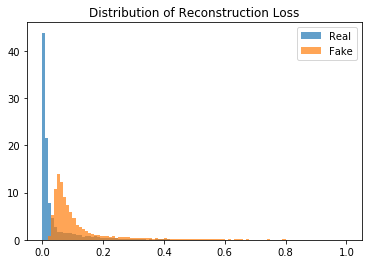

In [21]:
x_fake=make_fake_data(x_test,y_test,ds,num_fakes=7000,var_scale=1)
fig1, losses,fake_losses=compare_fit_with_fake_data(ae_321632,x_test,x_fake,loss=loss)

In [20]:

total_error_rate,type1_error_rate,type2_error_rate, clf=fit_model(losses,fake_losses)
total_error_rate


1148.0
4557.0
7000


0.40458123537337776

In [11]:
layers=model_3h(x_train,drop_ra=0.0,l1_reg=0, g_noise=0.05, ker_init=ker_init,nodes=nodes)

ae_321632_var=autoencoder(layers,name='321632',**train_dic)

loss_combi_var=make_loss_combi(0.5,sparse_recon_loss_combi,sparse_recon_loss_var)

ae_321632_var.loss=loss_combi_var
ae_321632_var.compile()
ae_321632_var.fit()

Train on 125204 samples, validate on 7101 samples
Epoch 1/100
125204/125204 [==============================] - 2s 15us/step - loss: 0.0948 - sparse_recon_loss_mse: 0.0683 - sparse_recon_loss_abs: 0.1459 - sparse_recon_loss_var: 0.1057 - val_loss: 0.0879 - val_sparse_recon_loss_mse: 0.0606 - val_sparse_recon_loss_abs: 0.1370 - val_sparse_recon_loss_var: 0.0999
Epoch 2/100
125204/125204 [==============================] - 1s 9us/step - loss: 0.0632 - sparse_recon_loss_mse: 0.0403 - sparse_recon_loss_abs: 0.1115 - sparse_recon_loss_var: 0.0719 - val_loss: 0.0768 - val_sparse_recon_loss_mse: 0.0506 - val_sparse_recon_loss_abs: 0.1236 - val_sparse_recon_loss_var: 0.0885
Epoch 3/100
125204/125204 [==============================] - 1s 9us/step - loss: 0.0565 - sparse_recon_loss_mse: 0.0355 - sparse_recon_loss_abs: 0.1050 - sparse_recon_loss_var: 0.0637 - val_loss: 0.0725 - val_sparse_recon_loss_mse: 0.0469 - val_sparse_recon_loss_abs: 0.1179 - val_sparse_recon_loss_var: 0.0838
Epoch 4/100
1252

125204/125204 [==============================] - 1s 9us/step - loss: 0.0405 - sparse_recon_loss_mse: 0.0240 - sparse_recon_loss_abs: 0.0821 - sparse_recon_loss_var: 0.0454 - val_loss: 0.0626 - val_sparse_recon_loss_mse: 0.0371 - val_sparse_recon_loss_abs: 0.0975 - val_sparse_recon_loss_var: 0.0761
Epoch 28/100
125204/125204 [==============================] - 1s 9us/step - loss: 0.0403 - sparse_recon_loss_mse: 0.0239 - sparse_recon_loss_abs: 0.0819 - sparse_recon_loss_var: 0.0452 - val_loss: 0.0624 - val_sparse_recon_loss_mse: 0.0369 - val_sparse_recon_loss_abs: 0.0968 - val_sparse_recon_loss_var: 0.0759
Epoch 29/100
125204/125204 [==============================] - 1s 9us/step - loss: 0.0401 - sparse_recon_loss_mse: 0.0237 - sparse_recon_loss_abs: 0.0816 - sparse_recon_loss_var: 0.0450 - val_loss: 0.0625 - val_sparse_recon_loss_mse: 0.0369 - val_sparse_recon_loss_abs: 0.0966 - val_sparse_recon_loss_var: 0.0762
Epoch 30/100
125204/125204 [==============================] - 1s 9us/step - l

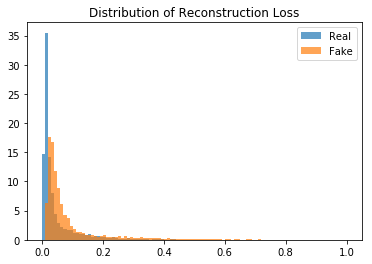

In [17]:
fig1, losses,fake_losses=compare_fit_with_fake_data(ae_321632_var,x_test,x_fake,loss=loss)

In [13]:
total_error_rate,type1_error_rate,type2_error_rate, clf=fit_model(losses,fake_losses)

1127.0
3353.0
7000
